### Original notebook from: https://www.kaggle.com/code/ttminh27/using-autoencoder-to-impute-missing-data

# Probabilistic circuit for handling missing data
!pip install deeprob-kit

Using a probabilistic circuit, a sum-product network, to autoencode missing data


In [1]:
# !pip install -e git+https://github.com/deeprob-org/deeprob-kit.git@main#egg=deeprob-kit
!pip install deeprob-kit
!pip install -q kaggle

In [98]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import tqdm
import math

print(f'tf version: {tf.__version__}')

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

tf version: 2.15.0


In [5]:
### Upload kaggle.json with API key
from google.colab import files
files.upload()

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle competitions download -c titanic
!unzip titanic.zip

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Fix random seed

In [7]:
seed = 42
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)
random.seed(seed)
np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# Load data

In [116]:
df_full = pd.read_csv('/content/train.csv')
df_valid = pd.read_csv('/content/test.csv')

df_full

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Define utils functions

## Normalize ticker number

In [117]:
def normalize_ticket(ticket_data):
    ticket_data = ticket_data.split()[0]
    ticket_data = re.sub('^\d+$', 'normal', ticket_data)
    ticket_data = re.sub('\.|/', '', ticket_data)
    return ticket_data

## Statistic of missing value

In [118]:
def statMissingValue(X):
    lstSummary = []
    for col in X.columns:
        liTotal = len(X.index)
        liMissing = X[col].isna().sum()
        lfMissingRate = round(liMissing * 100/liTotal,2)
        liZero = 0
        liNUnique = X[col].nunique()
        if(X[col].dtype!='object'):
            liZero = X[col].isin([0]).sum()
        lfZeroRate = round(liZero*100/liTotal,2)
        lstSummary.append([col,str(X[col].dtype),liTotal, liNUnique, liMissing, lfMissingRate,liZero,lfZeroRate])
    return pd.DataFrame(lstSummary,columns=['feature','col_type','total', 'unique', 'na','na_rate','zero','zero_rate'])


# EDA

## Review statistic on each feature

In [119]:
df_stat = statMissingValue(df_full)
print(df_stat.feature.to_list())
df_stat

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


,feature,col_type,total,unique,na,na_rate,zero,zero_rate
0,PassengerId,int64,891,891,0,0.00,0,0.00
1,Survived,int64,891,2,0,0.00,549,61.62
2,Pclass,int64,891,3,0,0.00,0,0.00
3,Name,object,891,891,0,0.00,0,0.00
4,Sex,object,891,2,0,0.00,0,0.00
5,Age,float64,891,88,177,19.87,0,0.00
6,SibSp,int64,891,7,0,0.00,608,68.24
7,Parch,int64,891,7,0,0.00,678,76.09
8,Ticket,object,891,681,0,0.00,0,0.00
9,Fare,float64,891,248,0,0.00,15,1.68


We notice that:
- "Pclass" has only 3 unique value so it mustbe categorical type. Same for "Sex", "Embarked".
- "Ticket" seems useless but if we split it, keep only first chunk (remove numeric part), it looks like categorial type.
- "Parch", "SibSp" are numeric type due to their definition.
- "Name" looks messy. We extract only the title part.

Plot the missing value rate of each feature

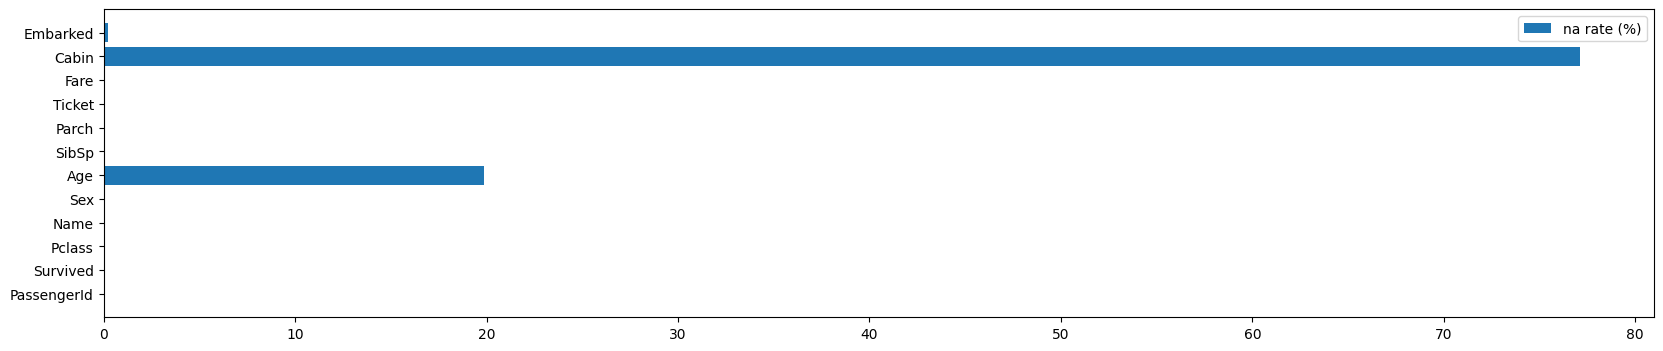

In [120]:
plt.figure(figsize=(20,4))
plt.barh(df_stat.feature, df_stat.na_rate, label='na rate (%)')
plt.legend()
plt.show()

- "Cabin" looks bad and need to remove instead of doing imputation.
- "Age" has only about 20% missing value and can be impute.
- "Embarked" has 0.22% of missing value and very good to impute.

## Define columns

In [191]:
col_id = [] #['PassengerId']
col_target = ['Survived']
col_cat_small =['Pclass', 'Sex', 'Embarked'] #['Pclass', 'Sex', 'Embarked','Name']
col_cat_big = ['Ticket','Cabin']
col_cat = col_cat_big + col_cat_small
col_num = ['Age', 'SibSp', 'Parch', 'Fare']

## Simple preprocess function

In [122]:
def simple_preprocess(X):
    df_ret =  X.copy()
    df_ret['Ticket']  = df_ret['Ticket'].apply(lambda x:normalize_ticket(x))
    df_ret['Name'] = df_ret['Name'].str.extract(r', (\w+\.)')
    df_ret[df_ret.Cabin.isna()] = 'null_value'
    return df_ret

## Review data and statistic after simple preprocess

In [123]:
simple_preprocess(df_full)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value
1,2,1,1,Mrs.,female,38.0,1,0,PC,71.2833,C85,C
2,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value
3,4,1,1,Mrs.,female,35.0,1,0,normal,53.1,C123,S
4,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value
...,...,...,...,...,...,...,...,...,...,...,...,...
886,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value
887,888,1,1,Miss.,female,19.0,0,0,normal,30.0,B42,S
888,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value,null_value
889,890,1,1,Mr.,male,26.0,0,0,normal,30.0,C148,C


In [124]:
statMissingValue(simple_preprocess(df_full))

,feature,col_type,total,unique,na,na_rate,zero,zero_rate
0,PassengerId,object,891,205,0,0.00,0,0.0
1,Survived,object,891,3,0,0.00,0,0.0
2,Pclass,object,891,4,0,0.00,0,0.0
3,Name,object,891,13,1,0.11,0,0.0
4,Sex,object,891,3,0,0.00,0,0.0
5,Age,object,891,64,19,2.13,0,0.0
6,SibSp,object,891,5,0,0.00,0,0.0
7,Parch,object,891,5,0,0.00,0,0.0
8,Ticket,object,891,11,0,0.00,0,0.0
9,Fare,object,891,101,0,0.00,0,0.0


In [125]:
simple_preprocess(df_full).Name.value_counts()

null_value    687
Mr.            93
Miss.          47
Mrs.           44
Master.         7
Dr.             3
Major.          2
Mlle.           2
Mme.            1
Lady.           1
Sir.            1
Col.            1
Capt.           1
Name: Name, dtype: int64

### Using DeepProbKit

In [126]:
df_nna = df_full.dropna()

df_nna.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [127]:
df_nna.drop(columns=['PassengerId', 'Name'], inplace=True)
df_full.drop(columns=['PassengerId', 'Name'], inplace=True)

<ipython-input-127-2ca628d0a0c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nna.drop(columns=['PassengerId', 'Name'], inplace=True)


In [128]:
CAT_VARS = ['Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']
def to_numeric_data(dataset_train, cat_vars = CAT_VARS):
  for col in dataset_train.columns:
    if col in cat_vars:
      dataset_train[col] = pd.factorize(dataset_train[col])[0]
    # else:
    #   dataset_train[col] = pd.to_numeric(dataset_train[col])
    return dataset_train

df_nna_num = to_numeric_data(df_nna)


In [129]:
# df_nna_num['Sex'] = pd.factorize(df_nna_num['Sex'])[0]
for col in CAT_VARS:
    df_nna_num[col] = pd.factorize(df_nna_num[col])[0]
    df_full[col] = pd.factorize(df_full[col])[0]
df_nna_num.head(3)

<ipython-input-129-26c21c7166a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nna_num[col] = pd.factorize(df_nna_num[col])[0]
<ipython-input-129-26c21c7166a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nna_num[col] = pd.factorize(df_nna_num[col])[0]
<ipython-input-129-26c21c7166a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,1,0,38.0,0,0,0,71.2833,0,0
3,1,1,0,35.0,0,0,1,53.1000,1,1
6,0,1,1,54.0,1,0,2,51.8625,2,1


In [130]:
from deeprob.spn.structure.leaf import Categorical, Gaussian, Bernoulli
import time, os
from deeprob.spn.algorithms.inference import *
from typing import Optional, Union, Tuple
from deeprob.spn.structure.node import Node
from deeprob.spn.learning.wrappers import learn_estimator
from deeprob.spn.utils.statistics import compute_statistics

In [131]:
df_full.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [132]:
print(df_nna_num.columns)
print(df_nna_num.dtypes)

for col in df_nna_num.columns:
    print(f"{col}: {df_nna_num[col].nunique()}")
df_nna_num.head(3)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')
Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Ticket        int64
Fare        float64
Cabin         int64
Embarked      int64
dtype: object
Survived: 2
Pclass: 3
Sex: 2
Age: 63
SibSp: 4
Parch: 4
Ticket: 127
Fare: 93
Cabin: 133
Embarked: 3


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,1,0,38.0,0,0,0,71.2833,0,0
3,1,1,0,35.0,0,0,1,53.1000,1,1
6,0,1,1,54.0,1,0,2,51.8625,2,1


In [91]:
max(df_nna_num['Cabin'].unique())

132

In [133]:
### SPECIFY THE DISTRIBUTION DESCRIBING EACH FEATURE: MATCH WITH ABOVE COLUMNS
distributions = [Bernoulli, Categorical, Bernoulli, Gaussian,
                 Categorical, Categorical, Categorical,
                 Gaussian, Categorical, Bernoulli ] # * 10 + [Categorical] + [Gaussian] * 5 + [Categorical, Bernoulli] + [Gaussian] * 3
### SPECIFY THE DOMAINS OF EACH DISTRIBUTION: MATCH WITH ABOVE PRINTED COLUMNS
domains =  [[0, 1], list(range(1, 3 + 1)), [0, 1], (0, 80 + 1),
            list(range(0, 4 + 1)), list(range(0, 4 + 1)), list(range(0, 126 + 1)),
            (0, 513 + 1), list(range(0, 132 + 1)), [0, 1]
            ] # * 10  + [list(range(2 + 1))] + [(0, 1)] * 5 + [list(range(16 + 1)), [0, 1]] + [(0, 1)] * 3
dfn = df_nna_num.values
spn = learn_estimator(
        data=dfn,
        distributions=distributions,
        domains=domains,
        random_state=42
    )

1/? [00:00, 105.29node/s]


In [134]:
df_full.isna().sum() # cabin is filled due to pd.factorize
df_full.replace(-1, math.nan, inplace=True)
df_full.isnull().any(axis=1)

0       True
1      False
2       True
3      False
4       True
       ...  
886     True
887    False
888     True
889    False
890     True
Length: 891, dtype: bool

In [135]:
df_full.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [136]:
nan_mask = df_full.isnull().any(axis=1)
nan_data = df_full[nan_mask]
### IMPUTATION IS DONE ONLY ON THE ENTRIES WITH MATH.NAN entries, unlike autoencoder where I can't control where it fills in missing values
mpe_nan_data = mpe(root = spn, x = nan_data.values)


In [137]:
mpe_nan_data

array([[ 0.   ,  3.   ,  0.   , ...,  7.25 ,  3.   ,  0.   ],
       [ 1.   ,  3.   ,  1.   , ...,  7.925,  3.   ,  0.   ],
       [ 0.   ,  3.   ,  0.   , ...,  8.05 ,  3.   ,  0.   ],
       ...,
       [ 0.   ,  2.   ,  0.   , ..., 13.   ,  3.   ,  0.   ],
       [ 0.   ,  3.   ,  1.   , ..., 23.45 ,  3.   ,  0.   ],
       [ 0.   ,  3.   ,  0.   , ...,  7.75 ,  3.   ,  2.   ]])

In [138]:
df_full_spn = df_full.copy()
df_full_spn[nan_mask] = mpe_nan_data
df_full_spn.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [148]:
likelihood_per_row = likelihood(spn, df_full_spn.values)
np.mean(likelihood_per_row)

1.1082337e-11

In [144]:
missing_cols = df_full.columns[df_full.isnull().any()].tolist()
df_mode_imputation = df_full.copy()
for col in missing_cols:
  df_mode_imputation[col].fillna(df_mode_imputation[col].mode()[0], inplace=True)


In [163]:
likelihood_per_row_mode = likelihood(spn, df_mode_imputation.values)
np.mean(likelihood_per_row_mode)

9.901252e-12

In [158]:
def impute_random_values(value):
    if value.ndim == 0:
        return value.size == 0
    elif value.ndim == 1:
        return value.size == 0
    else:
        return value.new(value.dtype)

# Impute random values for numerical columns
df_fill_random = df_full.fillna(method='ffill')
df_fill_random.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,0,22.0,0,0,0,7.2500,NaN,0.0
1,1,1,1,38.0,0,0,1,71.2833,0.0,1.0
2,1,3,1,26.0,1,0,2,7.9250,0.0,0.0
3,1,1,1,35.0,0,0,3,53.1000,1.0,0.0
4,0,3,0,35.0,1,0,4,8.0500,1.0,0.0


In [159]:
likelihood_per_row_rand = likelihood(spn, df_fill_random.values)
np.mean(likelihood_per_row_rand)

7.066738e-12

In [217]:
df_valid_nname = df_valid.drop(columns = ['PassengerId', 'Name'])
for col in CAT_VARS:
    df_valid_nname[col] = pd.factorize(df_valid_nname[col])[0]

df_valid_nname.insert(0, 'Survived', -1)
df_valid_na = df_valid_nname.replace(-1, math.nan)
df_valid_na.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,3,0,34.5,0,0,0,7.8292,NaN,0
1,NaN,3,1,47.0,1,0,1,7.0000,NaN,1
2,NaN,2,0,62.0,0,0,2,9.6875,NaN,0


In [218]:
test_nan_mask = df_valid_na.isnull().any(axis=1)
test_nan_data = df_valid_na[test_nan_mask]
### IMPUTATION IS DONE ONLY ON THE ENTRIES WITH MATH.NAN entries, unlike autoencoder where I can't control where it fills in missing values
mpe_test_nan_data = mpe(root = spn, x = test_nan_data.values)


In [219]:
mpe_test_nan_data

array([[ 1.    ,  3.    ,  0.    , ...,  7.8292,  3.    ,  0.    ],
       [ 1.    ,  3.    ,  1.    , ...,  7.    ,  3.    ,  1.    ],
       [ 1.    ,  2.    ,  0.    , ...,  9.6875,  3.    ,  0.    ],
       ...,
       [ 1.    ,  3.    ,  0.    , ...,  7.25  ,  3.    ,  1.    ],
       [ 1.    ,  3.    ,  0.    , ...,  8.05  ,  3.    ,  1.    ],
       [ 1.    ,  3.    ,  0.    , ..., 22.3583,  3.    ,  2.    ]])

In [221]:
df_valid_spn = df_valid_na.copy()
df_valid_spn[test_nan_mask] = mpe_test_nan_data
df_valid_spn.isna().sum()
df_valid_spn.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,3.0,0.0,34.5,0.0,0.0,0.0,7.8292,3.0,0.0
1,1.0,3.0,1.0,47.0,1.0,0.0,1.0,7.0000,3.0,1.0
2,1.0,2.0,0.0,62.0,0.0,0.0,2.0,9.6875,3.0,0.0
3,1.0,3.0,0.0,27.0,0.0,0.0,3.0,8.6625,3.0,1.0
4,1.0,3.0,1.0,22.0,1.0,1.0,4.0,12.2875,3.0,1.0


In [225]:
df_valid_spn['Survived'] == 0 # WTF

0      False
1      False
2      False
3      False
4      False
       ...  
413    False
414    False
415    False
416    False
417    False
Name: Survived, Length: 418, dtype: bool

## Original Notebook's training of a autoencoder to fill-in missing data and build a classifier.

## Fill in missing value from random

In [ ]:
#

In [170]:
def fill_na_with_random(df_ref, df_na):
    df_ret = df_na.copy()
    for col in df_ret.columns:
        ret_nan = df_ret[col][df_ret[col].isna()]
        ref_n_nan = df_ref[~df_ref[col].isna()][col]

        df_ret[col].loc[df_ret[col].isna()] = np.random.choice(ref_n_nan,size=len(ret_nan))
    return df_ret

# fill_na_with_random(df_xtrain, df_xtrain)

## Create noisy data by using permutate data in each column

In [164]:
def make_noisy(np_data):
    np_ret = np.copy(np_data)
    for i in range(np_ret.shape[1]):
        np.random.shuffle(np_ret[:,i])
    return np_ret

In [165]:
def mode_imputation(df, col):
    df[col].fillna(df[col].mode()[0], inplace=True)
    return df

def mean_imputation(df, col):
    df[col].fillna(df[col].mean()[0], inplace=True)
    return df

# Model

## Split dataset

In [175]:
df_valid.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [193]:
# x_full = df_full[col_num+col_cat]
# y_full = df_full[col_target]

x_full = df_full_spn.drop(columns=['Survived'])
y_full = df_full_spn['Survived']
# x_valid = df_valid[col_num+col_cat]
x_valid = df_valid.drop(columns=['PassengerId', 'Name'])

x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.25, random_state=6668)

x_ref = x_train.copy()

x_train = fill_na_with_random(x_ref, x_train)
x_test = fill_na_with_random(x_ref, x_test)
x_valid = fill_na_with_random(x_ref, x_valid)

# x_train = simple_preprocess(x_train)
# x_test = simple_preprocess(x_test)
# x_valid = simple_preprocess(x_valid)

<ipython-input-170-e38bb74c6ef7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ret[col].loc[df_ret[col].isna()] = np.random.choice(ref_n_nan,size=len(ret_nan))


In [195]:
# x_train.Name.value_counts()
x_train.head(5)

## Encode category pipeline

In [196]:
x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
839,1.0,0.0,35.674426,1.0,0.0,648.0,29.7000,140.0,1.0
28,3.0,1.0,35.674426,1.0,0.0,27.0,7.8792,3.0,2.0
387,2.0,1.0,36.000000,1.0,0.0,331.0,13.0000,3.0,0.0
797,3.0,1.0,31.000000,1.0,0.0,623.0,8.6833,3.0,0.0
261,3.0,0.0,3.000000,3.0,2.0,24.0,31.3875,3.0,0.0


In [197]:
# !pip install category_encoders

In [198]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.preprocessing import PowerTransformer
import category_encoders as ce
from xgboost import XGBClassifier
import lightgbm

# Preprocessing for numerical data
numerical_transformer = Pipeline(verbose=False,steps=[
    ('scale', StandardScaler(with_mean=True,with_std=True)),
])

# Preprocessing for categorical data
categorical_onehot_transformer = Pipeline(verbose=False,steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_count_transformer = Pipeline(verbose=False,steps=[
    ('count', ce.CountEncoder(min_group_size = 3)),
    ('scale', StandardScaler(with_mean=True,with_std=True)),
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(verbose=False,
    transformers=[
        ('pre_cat_count', categorical_count_transformer, col_cat_big),
        ('pre_cat_onehot', categorical_onehot_transformer, col_cat_small),
        ('pre_num', numerical_transformer, col_num),
    ])

## Execute encode category process

In [200]:
preprocessor.fit(x_train)
x_train_encoded =  preprocessor.transform(x_train)
x_test_encoded = preprocessor.transform(x_test)
# x_valid_encoded = preprocessor.transform(x_valid)

## Impute missing value using auto encoder

In [201]:
input_dim = x_train_encoded.shape[1]
model_impute = keras.Sequential()
model_impute.add(layers.Dense(20,activation='gelu', input_dim=input_dim, kernel_initializer='he_uniform'))
model_impute.add(layers.Dense(16,activation='gelu', kernel_initializer='he_uniform'))
model_impute.add(layers.Dense(10,activation='gelu', kernel_initializer='he_uniform', name='bottleneck'))
model_impute.add(layers.Dense(16,activation='gelu', kernel_initializer='he_uniform'))
model_impute.add(layers.Dense(20,activation='gelu', kernel_initializer='he_uniform'))
model_impute.add(layers.Dense(input_dim,activation='linear', kernel_initializer='he_uniform'))

optimizer = keras.optimizers.Adam(learning_rate=0.03)
model_impute.compile(optimizer = optimizer, loss = 'msle')
model_impute.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                300       
                                                                 
 dense_1 (Dense)             (None, 16)                336       
                                                                 
 bottleneck (Dense)          (None, 10)                170       
                                                                 
 dense_2 (Dense)             (None, 16)                176       
                                                                 
 dense_3 (Dense)             (None, 20)                340       
                                                                 
 dense_4 (Dense)             (None, 14)                294       
                                                                 
Total params: 1616 (6.31 KB)
Trainable params: 1616 (6.3

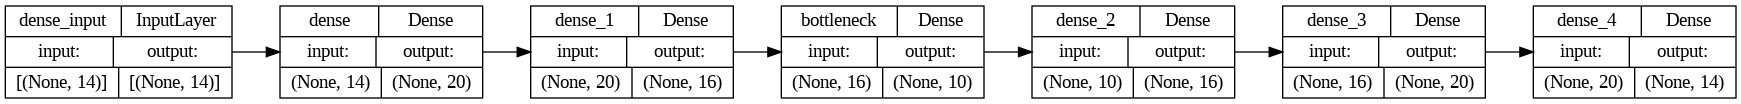

In [202]:
tf.keras.utils.plot_model(model_impute, show_shapes=True,rankdir='LR')

In [203]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50)

noise_X = make_noisy(x_train_encoded)
# noise_X = np.concatenate((noise_X, make_noisy(noise_X)), axis=0)
noise_X = np.concatenate((noise_X, np.copy(x_train_encoded)), axis=0)

his = model_impute.fit(noise_X, noise_X, epochs = 2000, batch_size = 512, shuffle = True, callbacks=[es], verbose=0)

Epoch 477: early stopping


In [205]:
x_train_encoded

(668, 14)

## Plot learning curve

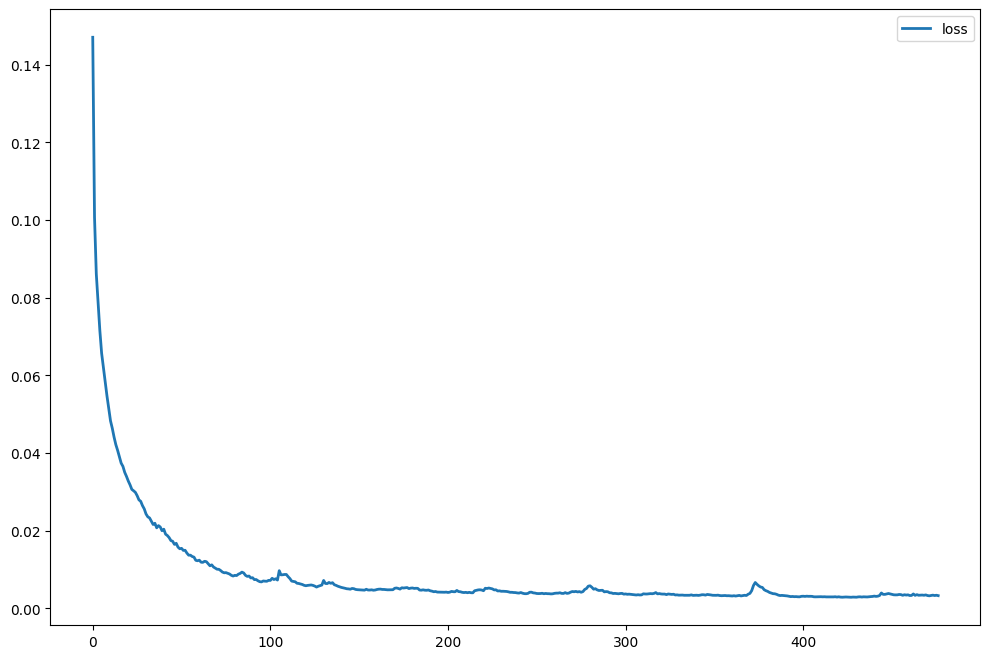

In [206]:
plt.figure(figsize=(12,8))
plt.plot(his.epoch,his.history['loss'], label='loss', linewidth=2)
plt.legend()
plt.show()

## Create final dataset with impute missing value by auto encoder

In [ ]:
x_train_impute = model_impute.predict(x_train_encoded)
x_test_impute = model_impute.predict(x_test_encoded)
x_valid_impute = model_impute.predict(x_valid_encoded)

In [ ]:
x_train_encoded

In [ ]:
x_train_impute

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

# Preprocess the data
def preprocess_data(df):
    continuous_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[object])

    scaler = MinMaxScaler()
    continuous_features = scaler.fit_transform(continuous_features)

    encoder = OneHotEncoder(sparse=False)
    categorical_features = encoder.fit_transform(categorical_features)

    return np.hstack([continuous_features, categorical_features])

# Create a mask for missing values
def create_missing_mask(df):
    return df.isnull()

# Build the autoencoder model
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Load and preprocess your dataset
df = df_full#pd.read_csv('your_dataset.csv')
missing_mask = create_missing_mask(df)
preprocessed_data = preprocess_data(df.fillna(df.mean()))




In [ ]:
df_full.mean()

In [ ]:
preprocessed_data.shape

In [ ]:
# Train the autoencoder
input_dim = preprocessed_data.shape[1]
encoding_dim = 64
autoencoder = build_autoencoder(input_dim, encoding_dim)
autoencoder.fit(preprocessed_data, preprocessed_data, epochs=5, batch_size=256, shuffle=True)

# Impute missing values
imputed_data = autoencoder.predict(preprocessed_data)
imputed_df = pd.DataFrame(imputed_data)
# imputed_df[missing_mask] = np.nan
# imputed_df.fillna(df.mean(), inplace=True)

In [ ]:
imputed_df

## Model predict survival

## Model for suvival prediction

In [ ]:
from sklearn.metrics import accuracy_score
def get_score(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

In [ ]:
# list_score = []
# for n_est in tqdm.tqdm(range(200,300,1)):
#     xgb = XGBClassifier(n_estimators=n_est)
#     xgb.fit(x_train_impute, y_train)
#     score = get_score(xgb,x_test_impute, y_test)
#     list_score.append([n_est,score])
# list_score = np.array(list_score)

In [ ]:
# plt.figure(figsize=(12,8))
# plt.plot(list_score[:,0],list_score[:,1], label='accurary')
# plt.legend()
# plt.show()

In [ ]:
# best_param = list_score[np.argmax(list_score[:,1])]
# best_param

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Best param
# best_n_est = int(best_param[0])
best_n_est = 1000
xgb = XGBClassifier(n_estimators=best_n_est, learning_rate=1e-3, seed=6688)
xgb.fit(x_train_impute, y_train)

print(f'train score: {get_score(xgb,x_train_impute,y_train)}')
print(f'test score: {get_score(xgb,x_test_impute,y_test)}')

## Submit result to leaderboard

In [ ]:
y_valid = xgb.predict(x_valid_impute)

In [ ]:
df_submit = pd.DataFrame({'PassengerId': df_valid.PassengerId, 'Survived': y_valid})
df_submit.head(3)

In [ ]:
df_submit.to_csv('submission.csv', index=False)
print("Submitted successful!")